## Python setup

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import pyspark.sql.functions as fx
from pyspark.sql.types import StringType
from pyspark.ml.linalg import Vector, Vectors, SparseVector, DenseMatrix
from pyspark.ml.stat import Summarizer
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.util import MLUtils

import json

from dataclasses import dataclass

import mlflow
import glow

spark = glow.register(spark)


## Reading the data

In [0]:
vcf_path = "/databricks-datasets/genomics/1kg-vcfs/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz"
vcf_view_unsplit = (spark.read.format('vcf').option('flattenInfoFields', 'false').load(vcf_path))

In [0]:
vcf_view_unsplit.count()

Out[79]: 1103547

## Paths to other data

In [0]:
phenotype_path = "/databricks-datasets/genomics/1000G/phenotypes.normalized"
sample_info_path = "/databricks-datasets/genomics/1000G/samples/populations_1000_genomes_samples.csv"

In [0]:
num_pcs = 5 #number of principal components

mlflow.log_param("principal components", num_pcs)

In [0]:
vcf_view = glow.transform("split_multiallelics", vcf_view_unsplit)
display(vcf_view.withColumn("genotypes", fx.col("genotypes")[0]))

contigName,start,end,names,referenceAllele,alternateAlleles,qual,filters,splitFromMultiAllelic,attributes,INFO_OLD_MULTIALLELIC,genotypes
22,16050074,16050075,List(rs587697622),A,List(G),100.0,List(PASS),false,"Map(AC -> 1, NS -> 2504, AFR_AF -> 0, VT -> SNP, AN -> 5008, SAS_AF -> 0.001, AA -> .|||, AF -> 0.000199681, EAS_AF -> 0, AMR_AF -> 0, DP -> 8012, EUR_AF -> 0)",null,"List(HG00096, true, List(0, 0))"
22,16050114,16050115,List(rs587755077),G,List(A),100.0,List(PASS),false,"Map(AC -> 32, NS -> 2504, AFR_AF -> 0.0234, VT -> SNP, AN -> 5008, SAS_AF -> 0, AA -> .|||, AF -> 0.00638978, EAS_AF -> 0, AMR_AF -> 0.0014, DP -> 11468, EUR_AF -> 0)",null,"List(HG00096, true, List(0, 0))"
22,16050212,16050213,List(rs587654921),C,List(T),100.0,List(PASS),false,"Map(AC -> 38, NS -> 2504, AFR_AF -> 0.0272, VT -> SNP, AN -> 5008, SAS_AF -> 0, AA -> .|||, AF -> 0.00758786, EAS_AF -> 0, AMR_AF -> 0.0014, DP -> 15092, EUR_AF -> 0.001)",null,"List(HG00096, true, List(0, 0))"
22,16050318,16050319,List(rs587712275),C,List(T),100.0,List(PASS),false,"Map(AC -> 1, NS -> 2504, AFR_AF -> 0, VT -> SNP, AN -> 5008, SAS_AF -> 0, AA -> .|||, AF -> 0.000199681, EAS_AF -> 0, AMR_AF -> 0.0014, DP -> 22609, EUR_AF -> 0)",null,"List(HG00096, true, List(0, 0))"
22,16050526,16050527,List(rs587769434),C,List(A),100.0,List(PASS),false,"Map(AC -> 1, NS -> 2504, AFR_AF -> 0, VT -> SNP, AN -> 5008, SAS_AF -> 0, AA -> .|||, AF -> 0.000199681, EAS_AF -> 0, AMR_AF -> 0, DP -> 23591, EUR_AF -> 0.001)",null,"List(HG00096, true, List(0, 0))"
22,16050567,16050568,List(rs587638893),C,List(A),100.0,List(PASS),false,"Map(AC -> 2, NS -> 2504, AFR_AF -> 0, VT -> SNP, AN -> 5008, SAS_AF -> 0, AA -> .|||, AF -> 0.000399361, EAS_AF -> 0.002, AMR_AF -> 0, DP -> 21258, EUR_AF -> 0)",null,"List(HG00096, true, List(0, 0))"
22,16050606,16050607,List(rs587720402),G,List(A),100.0,List(PASS),false,"Map(AC -> 5, NS -> 2504, AFR_AF -> 0, VT -> SNP, AN -> 5008, SAS_AF -> 0, AA -> .|||, AF -> 0.000998403, EAS_AF -> 0, AMR_AF -> 0.0014, DP -> 20274, EUR_AF -> 0.004)",null,"List(HG00096, true, List(0, 0))"
22,16050626,16050627,List(rs587593704),G,List(T),100.0,List(PASS),false,"Map(AC -> 2, NS -> 2504, AFR_AF -> 0, VT -> SNP, AN -> 5008, SAS_AF -> 0.001, AA -> .|||, AF -> 0.000399361, EAS_AF -> 0, AMR_AF -> 0.0014, DP -> 21022, EUR_AF -> 0)",null,"List(HG00096, true, List(0, 0))"
22,16050645,16050646,List(rs587670191),G,List(T),100.0,List(PASS),false,"Map(AC -> 1, NS -> 2504, AFR_AF -> 0, VT -> SNP, AN -> 5008, SAS_AF -> 0.001, AA -> .|||, AF -> 0.000199681, EAS_AF -> 0, AMR_AF -> 0, DP -> 22073, EUR_AF -> 0)",null,"List(HG00096, true, List(0, 0))"
22,16050653,16063474,"List(esv3647175, esv3647176, esv3647177, esv3647178)",A,List(),100.0,List(PASS),true,"Map(AC -> 9,87,599,20, NS -> 2504, AFR_AF -> 0.0061,0.0363,0.0053,0, VT -> SV, AN -> 5008, SAS_AF -> 0,0.0082,0.1094,0.002, AF -> 0.00179712,0.0173722,0.119609,0.00399361, EAS_AF -> 0.001,0.0169,0.2361,0.0099, AMR_AF -> 0,0.0101,0.219,0.0072, DP -> 22545, CS -> DUP_gs, END -> 16063474, EUR_AF -> 0,0.007,0.0944,0.003, SVTYPE -> CNV)",22:16050654:A////,"List(HG00096, true, List(-1, 0))"


In [0]:
vcf_view.count()

Out[50]: 1110240

In [0]:
vcf_view.select(glow.genotype_states(fx.col('genotypes'))).show(5)

In [0]:
vectorized = (vcf_view.select(glow.array_to_sparse_vector(glow.genotype_states(fx.col('genotypes'))).alias('features')).cache())

## Use SparkML to compute principal components

In [0]:
matrix = RowMatrix(MLUtils.convertVectorColumnsFromML(vectorized,'features').rdd.map(lambda x: x.features))
pcs = matrix.computeSVD(num_pcs)



In [0]:
pcs_results = pd.DataFrame(pcs.V.toArray())

In [0]:
matrix.numRows()

Out[90]: 1110240

In [0]:
pcs_df = spark.createDataFrame(pcs.V.toArray().tolist(), ["pc" + str(i) for i in range(num_pcs)])
sample_metadata = spark.read.option("header", True).csv(sample_info_path)
sample_info = get_sample_info(vcf_view, sample_metadata)
sample_count = sample_info.count()
mlflow.log_param("number of samples", sample_count)
pcs_indexed = pcs_df.coalesce(1).withColumn("index", fx.monotonically_increasing_id())
pcs_with_samples = pcs_indexed.join(sample_info, "index")

In [0]:
display(pcs_with_samples)

index,pc0,pc1,pc2,pc3,pc4,Sample,Population,super_population
0,0.019490758996048997,-0.00751745294136991,0.027427536609674,-0.01219692796634729,0.033725005043509754,HG00096,GBR,EUR
1,0.01930715383675621,-0.010885857084333827,0.02524842334782829,-0.005408388708107139,0.023586088001436925,HG00097,GBR,EUR
2,0.019164158835397023,-0.00835713495392091,0.027177318976768526,-0.010243334538545498,0.01510206522577345,HG00099,GBR,EUR
3,0.01933156581666457,-0.008400011467668902,0.02933072982623468,-0.010141679176170428,0.03215367597630641,HG00100,GBR,EUR
4,0.019635957569969133,-0.00812227169762545,0.02361664964803277,0.0037074483834640855,0.017189838824635654,HG00101,GBR,EUR
5,0.01949853889917069,-0.007248512167655673,0.027077804094072778,6.341368952538923E-4,0.023808412768263225,HG00102,GBR,EUR
6,0.01891466541756076,-0.007910591129270637,0.0279637876757721,0.006223685590914553,0.013152533886261027,HG00103,GBR,EUR
7,0.019506352670733806,-0.009945619708566177,0.028918622753655948,8.295940808977168E-4,0.021543901902519598,HG00105,GBR,EUR
8,0.019540344828938575,-0.010191967839674097,0.02353032904306734,-0.0012796168188543428,0.02391961885465642,HG00106,GBR,EUR
9,0.019209541897934605,-0.008853955115440983,0.02639416462575149,0.0035481170850549873,0.019403256712271763,HG00107,GBR,EUR


In [0]:
pcs_with_samples.count()

Out[84]: 2504

In [0]:
pcs_with_samples.groupBy('Population').count().show()

+----------+-----+
Population|count|
+----------+-----+
 GBR| 91|
 FIN| 99|
 CHS| 105|
 PUR| 104|
 CDX| 93|
 CLM| 94|
 IBS| 107|
 PEL| 85|
 PJL| 96|
 KHV| 99|
 ACB| 96|
 GWD| 113|
 ESN| 99|
 BEB| 86|
 MSL| 85|
 STU| 102|
 ITU| 102|
 CEU| 99|
 YRI| 108|
 CHB| 103|
+----------+-----+
only showing top 20 rows

In [0]:
pcs_with_samples.groupBy('super_population').count().show()

+----------------+-----+
super_population|count|
+----------------+-----+
 EUR| 503|
 EAS| 504|
 AMR| 347|
 SAS| 489|
 AFR| 661|
+----------------+-----+

Out[37]:

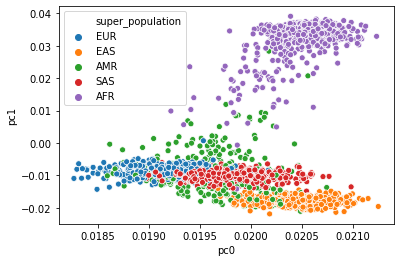

<matplotlib.axes._subplots.AxesSubplot at 0x7f0a06429ca0>

In [0]:
plt_dat = pcs_with_samples.toPandas()
sns.scatterplot(data = plt_dat, x = 'pc0', y = 'pc1', hue = 'super_population');

## Prepping for GWAS analysis

In [0]:
phenotype_df = pd.read_parquet('/dbfs/' + phenotype_path).explode('values').rename({'values': 'bmi'}, axis='columns').reset_index(drop=True)
del phenotype_df['phenotype']
phenotype_df

Out[24]:

,bmi
0,26.9
1,24.5
2,32.5
3,25.9
4,25.9
...,...
2499,23.1
2500,25.9
2501,25.9
2502,21.7


In [0]:
covariate_df = pcs_results
phenotype = phenotype_df.columns[0]
mlflow.log_param("phenotype", phenotype)

genotypes = vcf_view

In [0]:
results = glow.gwas.linear_regression(
   genotypes.select('contigName','start','genotypes'),
  phenotype_df,
  covariate_df,
  values_column = glow.genotype_states(fx.col('genotypes'))
)

--------------------------------------------------------------------------- 
 TypeError Traceback (most recent call last)
 <command-260370407862378> in <module> 
 1 results = glow.gwas.linear_regression(
 ----> 2 genotypes . select ( 'contigName' , 'start' , 'genotypes' ) , 
 3 phenotype_df , 
 4 covariate_df , 
 5 values_column = glow . genotype_states ( fx . col ( 'genotypes' ) ) 

 TypeError : 'Column' object is not callable

In [0]:
variants_path = 'dbfs:/databricks-datasets/genomics/gwas/hapgen-variants.delta'

phenotypes_path = '/dbfs/databricks-datasets/genomics/gwas/Ysim_test_simulation.csv'

covariates_path = '/dbfs/databricks-datasets/genomics/gwas/Covs_test_simulation.csv'

 

In [0]:
base_variant_df = spark.read.format('delta').load(variants_path)

In [0]:
base_variant_df.count()

Out[55]: 2206776

In [0]:
variant_df = (glow.transform('split_multiallelics', base_variant_df)
  .withColumn('values', glow.mean_substitute(glow.genotype_states('genotypes')))
  .filter(fx.size(fx.array_distinct('values')) > 1))

In [0]:
phenotype_df = pd.read_csv(phenotypes_path, index_col='sample_id')
phenotype_df

Out[57]:

,Trait_1,Trait_2,Trait_3,Trait_4,Trait_5,Trait_6,Trait_7,Trait_8,Trait_9,Trait_10
sample_id,,,,,,,,,,
ID_1,0.929502,1.706785,0.957977,0.201076,0.336925,0.677871,0.453833,0.715439,0.347466,-0.960814
ID_2,-0.896727,-0.056746,1.559868,-0.160429,1.641352,1.471509,1.594258,2.484681,2.299683,-1.253234
ID_3,0.419415,1.204712,-0.175954,-1.180814,0.735562,1.137936,-0.103351,0.901970,0.887996,-1.181853
ID_4,0.021952,0.933931,1.094844,-0.139890,1.443601,1.264320,0.796533,0.807244,1.181493,0.401100
ID_5,-0.818167,1.053858,1.841042,-1.066021,1.778600,0.312626,2.090397,0.972808,1.214688,-1.273327
...,...,...,...,...,...,...,...,...,...,...
ID_96,1.233004,0.533058,-0.858262,-1.028452,-0.901886,-0.761277,-0.780125,-0.447220,-1.194504,-0.722186
ID_97,-0.299945,-0.973475,-0.412174,0.714972,-0.767584,0.069775,-0.358166,-0.749388,-0.574218,0.431110
ID_98,0.486530,-0.082868,0.212963,0.409652,-0.055862,-0.528268,0.690797,0.226363,0.296245,0.244634


In [0]:
covariate_df = pd.read_csv(covariates_path, index_col='sample_id')
covariate_df

Out[58]:

,sharedConfounder1_bin1,independentConfounder2_cat_norm1,independentConfounder2_cat_norm2,independentConfounder3_cat_unif1,sharedConfounder4_norm1,independentConfounder4_norm1
sample_id,,,,,,
ID_1,0,1,3,1,0.959407,0.453171
ID_2,0,1,2,1,-0.693932,1.056243
ID_3,0,1,1,2,-2.583685,0.699771
ID_4,0,1,1,4,0.330019,-0.345447
ID_5,0,1,3,2,-0.773439,-0.500239
...,...,...,...,...,...,...
ID_96,1,1,3,1,-0.379550,-0.782762
ID_97,0,1,1,1,0.033311,-2.150547
ID_98,0,1,2,1,0.381711,-0.676522


In [0]:
offset_df = pd.read_csv(y_hat_path, dtype={'contigName': str}).set_index(['sample_id', 'contigName'])
offset_df

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-260370407862391> in <module> 
 ----> 1 offset_df = pd . read_csv ( y_hat_path , dtype = { 'contigName' : str } ) . set_index ( [ 'sample_id' , 'contigName' ] ) 
 2 offset_df

 NameError : name 'y_hat_path' is not defined

# Step 0: Prepare input paths

In [0]:
dbutils.widgets.text('variants_per_block', '1000')
dbutils.widgets.text('sample_block_count', '10')

variants_path = 'dbfs:/databricks-datasets/genomics/gwas/hapgen-variants.delta'
phenotypes_path = '/dbfs/databricks-datasets/genomics/gwas/Ysim_test_simulation.csv'
covariates_path = '/dbfs/databricks-datasets/genomics/gwas/Covs_test_simulation.csv'
 
block_matrix_path = 'dbfs:/tmp/wgr_block_matrix.delta'
sample_blocks_path = '/dbfs/tmp/sample_blocks.json'
y_hat_path = '/dbfs/tmp/wgr_y_hat.csv'
gwas_results_path = '/dbfs/tmp/wgr_gwas_results.delta'

variants_per_block = int(dbutils.widgets.get('variants_per_block'))
sample_block_count = int(dbutils.widgets.get('sample_block_count'))

In [0]:
base_variant_df = spark.read.format('delta').load(variants_path)

In [0]:
base_variant_df.count()

Out[65]: 2206776

In [0]:
variant_df = (glow.transform('split_multiallelics', base_variant_df)
  .withColumn('values', glow.mean_substitute(glow.genotype_states('genotypes')))
  .filter(fx.size(fx.array_distinct('values')) > 1))

In [0]:
sample_ids = glow.wgr.get_sample_ids(base_variant_df)

In [0]:
block_df, sample_blocks = glow.wgr.block_variants_and_samples(variant_df, 
                                                     sample_ids, 
                                                     variants_per_block, 
                                                     sample_block_count)

In [0]:
label_df = pd.read_csv(phenotypes_path, index_col='sample_id')
label_df

Out[70]:

,Trait_1,Trait_2,Trait_3,Trait_4,Trait_5,Trait_6,Trait_7,Trait_8,Trait_9,Trait_10
sample_id,,,,,,,,,,
ID_1,0.929502,1.706785,0.957977,0.201076,0.336925,0.677871,0.453833,0.715439,0.347466,-0.960814
ID_2,-0.896727,-0.056746,1.559868,-0.160429,1.641352,1.471509,1.594258,2.484681,2.299683,-1.253234
ID_3,0.419415,1.204712,-0.175954,-1.180814,0.735562,1.137936,-0.103351,0.901970,0.887996,-1.181853
ID_4,0.021952,0.933931,1.094844,-0.139890,1.443601,1.264320,0.796533,0.807244,1.181493,0.401100
ID_5,-0.818167,1.053858,1.841042,-1.066021,1.778600,0.312626,2.090397,0.972808,1.214688,-1.273327
...,...,...,...,...,...,...,...,...,...,...
ID_96,1.233004,0.533058,-0.858262,-1.028452,-0.901886,-0.761277,-0.780125,-0.447220,-1.194504,-0.722186
ID_97,-0.299945,-0.973475,-0.412174,0.714972,-0.767584,0.069775,-0.358166,-0.749388,-0.574218,0.431110
ID_98,0.486530,-0.082868,0.212963,0.409652,-0.055862,-0.528268,0.690797,0.226363,0.296245,0.244634


In [0]:
covariate_df = pd.read_csv(covariates_path, index_col='sample_id')
covariate_df

Out[71]:

,sharedConfounder1_bin1,independentConfounder2_cat_norm1,independentConfounder2_cat_norm2,independentConfounder3_cat_unif1,sharedConfounder4_norm1,independentConfounder4_norm1
sample_id,,,,,,
ID_1,0,1,3,1,0.959407,0.453171
ID_2,0,1,2,1,-0.693932,1.056243
ID_3,0,1,1,2,-2.583685,0.699771
ID_4,0,1,1,4,0.330019,-0.345447
ID_5,0,1,3,2,-0.773439,-0.500239
...,...,...,...,...,...,...
ID_96,1,1,3,1,-0.379550,-0.782762
ID_97,0,1,1,1,0.033311,-2.150547
ID_98,0,1,2,1,0.381711,-0.676522


In [0]:
def chunk_columns(df, chunk_size):
  for start in range(0, df.shape[1], chunk_size):
    chunk = df.iloc[:, range(start, min(start + chunk_size, df.shape[1]))]
    yield chunk

In [0]:
chunk_size = 10
loco_estimates = []
for label_df_chunk in chunk_columns(label_df, chunk_size):
  loco_estimates.append(glow.wgr.estimate_loco_offsets(block_df, label_df_chunk, sample_blocks, covariate_df))

The label DataFrame is quantitative. Reduction/regression for quantitative phenotypes will be applied.
Generated alphas: [ 664469.6969697 877100. 1315650. 2631300.
 65782500. ]

--------------------------------------------------------------------------- 
 TypeError Traceback (most recent call last)
 <command-260370407862402> in <module> 
 2 loco_estimates = [ ] 
 3 for label_df_chunk in chunk_columns ( label_df , chunk_size ) : 
 ----> 4 loco_estimates . append ( glow . wgr . estimate_loco_offsets ( block_df , label_df_chunk , sample_blocks , covariate_df ) ) 

 /databricks/python/lib/python3.8/site-packages/glow/wgr/wgr_functions.py in estimate_loco_offsets (block_df, label_df, sample_blocks, cov_df, add_intercept, reduction_alphas, regression_alphas, label_type, chromosomes) 
 249 chromosome as the primary sort key , and sample ID as the secondary sort key . 
 250 """
 --> 251 ridge_reduced = RidgeReduction(block_df, label_df, sample_blocks, cov_df, add_intercept,
 252 reduction_alphas, label_type)
 253 

 /databricks/python/lib/python3.8/site-packages/typeguard/__init__.py in wrapper (*args, **kwargs) 
 838 memo = _CallMemo ( python_func , _localns , args = args , kwargs = kwargs ) 
 839 check_argument_types ( memo ) 
 --> 840 retval = func ( * args , ** kwargs ) 
 841 check_return_type ( retval , memo ) 
 842 

 /databricks/python/lib/python3.8/site-packages/glow/wgr/ridge_reduction.py in __init__ (self, block_df, label_df, sample_blocks, cov_df, add_intercept, alphas, label_type) 
 66 self . set_label_df ( label_df ) 
 67 self . set_cov_df ( cov_df , add_intercept ) 
 ---> 68 self . set_alphas ( alphas ) 
 69 self . model_df = None 
 70 self . reduced_block_df = None 

 /databricks/python/lib/python3.8/site-packages/typeguard/__init__.py in wrapper (*args, **kwargs) 
 838 memo = _CallMemo ( python_func , _localns , args = args , kwargs = kwargs ) 
 839 check_argument_types ( memo ) 
 --> 840 retval = func ( * args , ** kwargs ) 
 841 check_return_type ( retval , memo ) 
 842 

 /databricks/python/lib/python3.8/site-packages/glow/wgr/ridge_reduction.py in set_alphas (self, alphas) 
 100 
 101 def set_alphas ( self , alphas : NDArray [ ( Any , ) , Float ] ) -> None : 
 --> 102 self._alphas = generate_alphas(
 103 self.block_df) if alphas.size == 0 else create_alpha_dict(alphas)
 104 

 /databricks/python/lib/python3.8/site-packages/typeguard/__init__.py in wrapper (*args, **kwargs) 
 838 memo = _CallMemo ( python_func , _localns , args = args , kwargs = kwargs ) 
 839 check_argument_types ( memo ) 
 --> 840 retval = func ( * args , ** kwargs ) 
 841 check_return_type ( retval , memo ) 
 842 

 /databricks/python/lib/python3.8/site-packages/glow/wgr/model_functions.py in generate_alphas (blockdf) 
 460 alphas = np . array ( [ num_label_free_headers / h for h in heritability_vals ] ) 
 461 print ( f"Generated alphas: {alphas}" ) 
 --> 462 return create_alpha_dict ( alphas ) 
 463 
 464 

 /databricks/python/lib/python3.8/site-packages/typeguard/__init__.py in wrapper (*args, **kwargs) 
 839 check_argument_types ( memo ) 
 840 retval = func ( * args , ** kwargs ) 
 --> 841 check_return_type ( retval , memo ) 
 842 
 843 # If a generator is returned, wrap it if its yield/send/return types can be checked 

 /databricks/python/lib/python3.8/site-packages/typeguard/__init__.py in check_return_type (retval, memo) 
 663 check_type ( 'the return value' , retval , memo . type_hints [ 'return' ] , memo ) 
 664 except TypeError as exc : # suppress unnecessarily long tracebacks 
 --> 665 raise exc from None 
 666 
 667 return True 

 /databricks/python/lib/python3.8/site-packages/typeguard/__init__.py in check_return_type (retval, memo) 
 661 
 662 try : 
 --> 663 check_type ( 'the return value' , retval , memo . type_hints [ 'return' ] , memo ) 
 664 except TypeError as exc : # suppress unnecessarily long tracebacks 
 665 raise exc from None 

 /databricks/python/lib/python3.8/site-packages/typeguard/__init__.py in check_type (argname, value, expected_type, memo, globals, locals) 
 591 checker_func = origin_type_checkers . get ( origin_type ) 
 592 if checker_func : 
 --> 593 checker_func ( argname , value , ex